First goal is to find an endpoint for Form 4's

https://www.sec.gov/developer

https://www.sec.gov/os/accessing-edgar-data

In [1]:
import requests
import time
import datetime
import pandas as pd
import os
import dotenv
import xml.etree.ElementTree as ET
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
dotenv.load_dotenv()
run_once_override = False

HEADERS = {
    'User-Agent': 'Personal User {}'.format(os.getenv("EMAIL")),
    'Accept-Encoding': 'gzip, deflate',
    'Host': 'www.sec.gov'
}

def SEC_API_sleep():
    # Be a good citizen! Limit requests to less than 10 per second
    time.sleep(0.11)
    

Fetch the list of CIKs from here https://www.sec.gov/Archives/edgar/cik-lookup-data.txt

In [3]:
def get_url_to_outfilename(url, outfilename, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print("Status Code:", response.status_code)
    with open(outfilename, "w", encoding="utf-8") as outfile:
        outfile.write(response.text)
    SEC_API_sleep()
    return response

In [4]:
get_url_to_outfilename(
    "https://www.sec.gov/Archives/edgar/cik-lookup-data.txt",
    "cik_list.txt"
)

-1

In [5]:
get_url_to_outfilename(
    "https://www.sec.gov/files/company_tickers.json",
    "company_tickers.json"
)

-1

In [6]:
def generate_interested_companies_dict():
    interested_company_names = []
    return_dict = dict()
    with open("interested_company_names.txt","r") as infile:
        for line in infile:
            interested_company_names.append(line.strip())
    with open("cik_list.txt","r") as infile:
        for line in infile:
            for name in interested_company_names:
                if name in line:
                    cik_number = int(line.split(":")[1])
                    cik_name = line.split(":")[0]
                    return_dict[cik_number] = {"name": cik_name}
    return return_dict

In [7]:
interested_companies_dict = generate_interested_companies_dict()

We can get information about a specific CIK's filings by querying this resource:

https://data.sec.gov/submissions/CIK##########.json

In [8]:
def save_interested_companies_indices(interested_companies_dict, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    for cik in interested_companies_dict:
        url = "https://data.sec.gov/submissions/CIK{:010d}.json".format(cik)
        get_url_to_outfilename(
            "https://data.sec.gov/submissions/CIK{:010d}.json".format(cik),
            "{}.html".format(cik),
            run_once_override=run_once_override
        )
    return 0

The above URL is not fetching. Let's try something else.

https://www.sec.gov/os/accessing-edgar-data

According to the above, use https://www.sec.gov/Archives/edgar/full-index/ to get an index per quarter of all filings from all companies. Let's write a function to grab the latest index and parse out relevant links for our `interested_companies_dict`

We want the `master.idx` file which contains data in this format: `CIK|Company Name|Form Type|Date Filed|Filename`

The full path to this file looks like:

`https://www.sec.gov/Archives/edgar/full-index/{YYYY}/QTR{1-4}/master.idx`

Data extends from 1993 QTR1 - 2023 QTR1

In [9]:
def get_master_index_for_year_and_quarter(year, quarter, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    get_url_to_outfilename(
        "https://www.sec.gov/Archives/edgar/full-index/{}/QTR{}/master.idx".format(year, quarter),
        "indices/{}Q{}_master.idx".format(year, quarter),
        run_once_override=run_once_override
    )
    return 0

In [10]:
get_master_index_for_year_and_quarter(2023, 1)

-1

Let's grab all indices since 1993 QTR1, then we can aggregate them together for one unified master index that we can parse for companies we're interested in.

First we'll grab all indices.

In [11]:
def get_all_master_indices(run_once_override=run_once_override, start_year=1993):
    if not run_once_override:
        return -1
    end_year = pd.Timestamp(datetime.datetime.now()).year
    end_quarter = pd.Timestamp(datetime.datetime.now()).quarter
    for year in range(start_year, end_year + 1):
        end_quarter_range = 4 if year != end_year else end_quarter
        for quarter in range(1, end_quarter_range + 1):
            print("Fetchin index for {}Q{}".format(year, quarter))
            get_master_index_for_year_and_quarter(year, quarter, run_once_override)
    return 0

In [12]:
get_all_master_indices()

-1

Let's also write a function to fetch only the latest index (for updates while the current quarter is ongoing).

In [13]:
def get_latest_master_index(run_once_override=run_once_override):
    if not run_once_override:
        return -1
    year = pd.Timestamp(datetime.datetime.now()).year
    quarter = pd.Timestamp(datetime.datetime.now()).quarter
    print("Fetchin index for {}Q{}".format(year, quarter))
    get_master_index_for_year_and_quarter(year, quarter, run_once_override)
    return 0

In [14]:
get_latest_master_index()

-1

Nice, now to read data. Here's what I want to do:

1. Read all index files.
2. Grab rows for CIKs that I'm interested in, based on `interested_companies_dict`
3. Output rows as a pandas dataframe

In [15]:
index_files = ["indices/" + filepath for filepath in os.listdir("indices")]
index_files[-1]

'indices/2023Q1_master.idx'

In [16]:
index_column_names = ["CIK","Company Name","Form Type","Date Filed","Filename"]
index_dataframe = pd.read_csv(index_files[-1], sep = "|", skiprows=11, names=index_column_names)
index_dataframe[index_dataframe["CIK"].isin(interested_companies_dict)]

,CIK,Company Name,Form Type,Date Filed,Filename
23906,1108524,"Salesforce, Inc.",10-K,2023-03-08,edgar/data/1108524/0001108524-23-000011.txt
23907,1108524,"Salesforce, Inc.",13F-HR,2023-02-10,edgar/data/1108524/0001108524-23-000005.txt
23908,1108524,"Salesforce, Inc.",3,2023-03-03,edgar/data/1108524/0001127602-23-008948.txt
23909,1108524,"Salesforce, Inc.",3,2023-03-03,edgar/data/1108524/0001127602-23-008950.txt
23910,1108524,"Salesforce, Inc.",3,2023-03-03,edgar/data/1108524/0001418812-23-000017.txt
...,...,...,...,...,...
23995,1108524,"Salesforce, Inc.",8-K,2023-01-27,edgar/data/1108524/0001193125-23-017661.txt
23996,1108524,"Salesforce, Inc.",8-K,2023-03-01,edgar/data/1108524/0001108524-23-000007.txt
23997,1108524,"Salesforce, Inc.",SC 13G/A,2023-02-07,edgar/data/1108524/0001306550-23-008329.txt
23998,1108524,"Salesforce, Inc.",SC 13G/A,2023-02-09,edgar/data/1108524/0000315066-23-002031.txt


Okay, I have the pieces to read the data correctly from the files and to focus on only the companies I care about. The last step is figure out how to concatenate two dataframes together.

Looks like `pd.concat([list of dataframes])` will do the job. Time to stitch it all together.

In [17]:
def print_percent_complete(step, total):
    print("{:.2f}% complete".format( (step / total) * 100), end = "\r")

In [34]:
def get_index_dataframe_for_interested_companies(interested_companies_dict, interested_forms=None, tail=None):
    index_files = ["indices/" + filepath for filepath in os.listdir("indices")]
    if tail:
        index_files = index_files[-tail:]
    index_column_names = ["CIK","Company Name","Form Type","Date Filed","Filename"]
    return_dataframe = pd.DataFrame()
    for i in range(len(index_files)):
        index_file = index_files[i]
        index_dataframe = pd.read_csv(index_file, sep = "|", skiprows=11, names=index_column_names)
        index_dataframe = index_dataframe[
            index_dataframe["CIK"].isin(interested_companies_dict)
        ]
        if interested_forms is not None:
            index_dataframe = index_dataframe[
                index_dataframe["Form Type"].isin(interested_forms)
            ]
        return_dataframe = pd.concat([return_dataframe, index_dataframe])
        print_percent_complete(i, len(index_files) - 1)
    print()
    return_dataframe['Filename'] = "https://www.sec.gov/Archives/" + return_dataframe['Filename']
    return return_dataframe.reset_index(drop=True)

In [35]:
interested_company_form_4_index = get_index_dataframe_for_interested_companies(
    interested_companies_dict, 
    ["4"], 
    5
)
interested_company_form_4_index

100.00% complete


,CIK,Company Name,Form Type,Date Filed,Filename
0,1108524,"SALESFORCE.COM, INC.",4,2022-01-05,https://www.sec.gov/Archives/edgar/data/110852...
1,1108524,"SALESFORCE.COM, INC.",4,2022-01-05,https://www.sec.gov/Archives/edgar/data/110852...
2,1108524,"SALESFORCE.COM, INC.",4,2022-01-06,https://www.sec.gov/Archives/edgar/data/110852...
3,1108524,"SALESFORCE.COM, INC.",4,2022-01-06,https://www.sec.gov/Archives/edgar/data/110852...
4,1108524,"SALESFORCE.COM, INC.",4,2022-01-10,https://www.sec.gov/Archives/edgar/data/110852...
...,...,...,...,...,...
416,1108524,"Salesforce, Inc.",4,2023-03-15,https://www.sec.gov/Archives/edgar/data/110852...
417,1108524,"Salesforce, Inc.",4,2023-03-15,https://www.sec.gov/Archives/edgar/data/110852...
418,1108524,"Salesforce, Inc.",4,2023-03-16,https://www.sec.gov/Archives/edgar/data/110852...
419,1108524,"Salesforce, Inc.",4,2023-03-17,https://www.sec.gov/Archives/edgar/data/110852...


Great! I can grab the locations of the forms I want. Now to pull the data for those actual forms...

In [20]:
edgar_archive_url_root = "https://www.sec.gov/Archives/"

In [21]:
form_4_urls_to_collect = [edgar_archive_url_root + i for i in interested_company_form_4_index["Filename"]]

In [22]:
def get_forms_from_url_list(form_urls_to_collect, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    for i in range(len(form_urls_to_collect)):
        form_url = form_urls_to_collect[i]
        get_url_to_outfilename(
            form_url,
            "forms/" + form_url.split("/")[-1],
            run_once_override
        )
        print_percent_complete(i, len(form_urls_to_collect) - 1)
    print()
    return 0

In [29]:
get_forms_from_url_list(form_4_urls_to_collect) 

-1

In [24]:
form_4_paths = ["forms/" + filepath for filepath in os.listdir("forms")]
form_4_paths

[]

Time to parse the XML and extract key form 4 data...

In [25]:
def get_XML_tree_from_file_path(file_path):
    file_lines = []
    with open(file_path, "r") as infile:
        file_lines = infile.readlines()
    XML_string = "".join(file_lines[file_lines.index('<XML>\n')+1:file_lines.index('</XML>\n')])
    return ET.fromstring(XML_string)

Okay we've sort of figured out how to walk through the XML tree, let's define the data we're trying to extract:

1. Name of Reporting Person
2. Title of Reporting Person
3. Issuer Name
4. Issuer Ticker
5. Non-Derivative Securities
    * Title of Security
    * Date
    * Code
    * Amount
    * Security Acquired or Disposed A / D
    * Price
    * Amount Total Following Reported Transaction
    * Ownership Direct or Indirect D / I
    * Nature of Indirect Beneficial Ownership
6. Derivative Securities
    * Title of Security
    * Exercise Price
    * Date
    * Code
    * Amount
    * Security Acquired or Disposed A / D
    * Date Exercisable
    * Date of Expiry
    * Title of Security Underlying
    * Amount of Security Underlying
    * Price of Derivative Security
    * Amount of Derivative Security Total Following Reported Transaction
    * Ownership Form Direct or Indirect D / A
    * Nature of Indirect Beneficial Ownership

In [26]:
XML_tree = get_XML_tree_from_file_path(form_4_paths[-1])
[i for i in XML_tree]

IndexError: list index out of range

In [67]:
def get_text_from_XML_tree_and_xpath_string(XML_tree, xpath):
    result = XML_tree.find(xpath)
    return result.text if result is not None else result

In [68]:
def get_form_4_dict_from_XML_tree(XML_tree):
    form_4_dict = {
        "name_of_reporting_person": 
        get_text_from_XML_tree_and_xpath_string(XML_tree, './reportingOwner/reportingOwnerId/rptOwnerName'),
        "title_of_reporting_person": 
        get_text_from_XML_tree_and_xpath_string(XML_tree, './reportingOwner/reportingOwnerRelationship/officerTitle'),
        "issuer_name":
        get_text_from_XML_tree_and_xpath_string(XML_tree, './issuer/issuerName'),
        "issuer_ticker":
        get_text_from_XML_tree_and_xpath_string(XML_tree, './issuer/issuerTradingSymbol'),
        "non_derivative_table": [
            {
                "title_of_security":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './securityTitle/value'),
                "transaction_date":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './transactionDate/value'),
                "transaction_code":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './transactionCoding/transactionCode'),
                "amount_of_shares":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './transactionAmounts/transactionShares/value'),
                "security_acquired_or_disposed":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './transactionAmounts/transactionAcquiredDisposedCode/value'),
                "price":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './transactionAmounts/transactionPricePerShare/value'),
                "amount_owned_following_transaction":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './postTransactionAmounts/sharesOwnedFollowingTransaction/value'),
                "ownership_direct_or_indirect":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './ownershipNature/directOrIndirectOwnership/value'),
                "nature_of_indirect_ownership":
                get_text_from_XML_tree_and_xpath_string(non_derivative_transaction, './ownershipNature/natureOfOwnership/value'),
            } for non_derivative_transaction in XML_tree.find('./nonDerivativeTable').findall('nonDerivativeTransaction')
        ],
        "derivative_table": [
            {
                "title_of_security":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './securityTitle/value'),
                "transaction_date":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './transactionDate/value'),
                "transaction_code":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './transactionCoding/transactionCode'),
                "amount_of_shares":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './transactionAmounts/transactionShares/value'),
                "security_acquired_or_disposed":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './transactionAmounts/transactionAcquiredDisposedCode/value'),
                "price":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './transactionAmounts/transactionPricePerShare/value'),
                "amount_owned_following_transaction":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './postTransactionAmounts/sharesOwnedFollowingTransaction/value'),
                "ownership_direct_or_indirect":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './ownershipNature/directOrIndirectOwnership/value'),
                "nature_of_indirect_ownership":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './ownershipNature/natureOfOwnership/value'),
                "date_exercisable":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './exerciseDate/value'),
                "date_of_expiry":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './expirationDate/value'),
                "title_of_security_underlying":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './underlyingSecurity/underlyingSecurityTitle/value'),
                "amount_of_security_underlying":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './underlyingSecurity/underlyingSecurityShares/value'),
                "exercise_price":
                get_text_from_XML_tree_and_xpath_string(derivative_transaction, './conversionOrExercisePrice/value'),
            } for derivative_transaction in XML_tree.find('./derivativeTable').findall('derivativeTransaction')
        ]
    }
    return form_4_dict

In [69]:
form_4_dict = get_form_4_dict_from_XML_tree(XML_tree)
form_4_dict

{'name_of_reporting_person': 'Weaver Amy E',
 'title_of_reporting_person': 'President and CFO',
 'issuer_name': 'SALESFORCE.COM, INC.',
 'issuer_ticker': 'CRM',
 'non_derivative_table': [{'title_of_security': 'Common Stock',
   'transaction_date': '2022-01-03',
   'transaction_code': 'M',
   'amount_of_shares': '1835',
   'security_acquired_or_disposed': 'A',
   'price': '118.04',
   'amount_owned_following_transaction': '25877',
   'ownership_direct_or_indirect': 'D',
   'nature_of_indirect_ownership': None},
  {'title_of_security': 'Common Stock',
   'transaction_date': '2022-01-03',
   'transaction_code': 'M',
   'amount_of_shares': '2550',
   'security_acquired_or_disposed': 'A',
   'price': '161.50',
   'amount_owned_following_transaction': '28427',
   'ownership_direct_or_indirect': 'D',
   'nature_of_indirect_ownership': None},
  {'title_of_security': 'Common Stock',
   'transaction_date': '2022-01-03',
   'transaction_code': 'M',
   'amount_of_shares': '1375',
   'security_acqu

In [77]:
def get_form_4_transaction_dataframe_from_form_4_dict(form_4_dict):
    non_derivative_dataframe = pd.DataFrame(form_4_dict['non_derivative_table'])
    derivative_dataframe = pd.DataFrame(form_4_dict['derivative_table'])
    return_dataframe = pd.concat([non_derivative_dataframe, derivative_dataframe])
    keys_to_add_to_all_rows = [
        'name_of_reporting_person', 
        'title_of_reporting_person',
        'issuer_name',
        'issuer_ticker'
    ]
    for key in keys_to_add_to_all_rows:
        return_dataframe[key] = form_4_dict[key]
    column_order = [
        'issuer_name',
        'issuer_ticker',
        'name_of_reporting_person',
        'title_of_reporting_person',    
        'title_of_security',
        'transaction_date',
        'transaction_code',
        'amount_of_shares',
        'security_acquired_or_disposed',
        'price',
        'amount_owned_following_transaction',
        'ownership_direct_or_indirect',
        'nature_of_indirect_ownership',
        'date_exercisable',
        'date_of_expiry',
        'title_of_security_underlying',
        'amount_of_security_underlying',
        'exercise_price',
    ]
    return_dataframe = return_dataframe[column_order]
    return_dataframe['transaction_date'] = pd.to_datetime(return_dataframe['transaction_date'])
    return_dataframe['amount_of_shares'] = return_dataframe['amount_of_shares'].astype(pd.Int64Dtype())
    return_dataframe['price'] = return_dataframe['price'].astype(np.float64)
    return_dataframe['amount_owned_following_transaction'] = return_dataframe['amount_owned_following_transaction'].astype(pd.Int64Dtype())
    return_dataframe['date_exercisable'] = pd.to_datetime(return_dataframe['date_exercisable'])
    return_dataframe['date_of_expiry'] = pd.to_datetime(return_dataframe['date_of_expiry'])
    return_dataframe['amount_of_security_underlying'] = return_dataframe['amount_of_security_underlying'].astype(pd.Int64Dtype())
    return_dataframe['exercise_price'] = return_dataframe['exercise_price'].astype(np.float64)
    return return_dataframe.reset_index(drop=True)

form_4_dataframe = get_form_4_transaction_dataframe_from_form_4_dict(form_4_dict)

Now, let's pull together a few form 4's into one dataframe so we can start plotting time series data.

In [76]:
def get_form_4_dataframe_from_form_4_filepath_list(form_4_filepath_list):
    return_dataframe = pd.DataFrame()
    for filepath in form_4_filepath_list:
        XML_tree = get_XML_tree_from_file_path(filepath)
        form_4_dict = get_form_4_dict_from_XML_tree(XML_tree)
        dataframe = get_form_4_transaction_dataframe_from_form_4_dict(form_4_dict)
        return_dataframe = pd.concat([return_dataframe, dataframe])
    return return_dataframe.reset_index(drop=True)

In [78]:
conditions = [
    (form_4_dataframe['transaction_code']=='S'),
    (form_4_dataframe['transaction_code']=='M') & (form_4_dataframe['title_of_security']=='Common Stock'),
    (form_4_dataframe['transaction_code']=='M') & (form_4_dataframe['title_of_security']=='Non-qualified Stock Option (Right to Buy)'),
]

values = [
    form_4_dataframe['amount_of_shares'] * form_4_dataframe['price'],
    form_4_dataframe['amount_of_shares'] * form_4_dataframe['price'],
    form_4_dataframe['amount_of_shares'] * form_4_dataframe['exercise_price'],
]

form_4_dataframe['dollars_moved'] = np.select(conditions, values)

form_4_dataframe[[
    'title_of_security',
    'security_acquired_or_disposed',
    'transaction_code',
    'amount_of_shares',
    'price',
    'exercise_price', 
    'dollars_moved'
]]

,title_of_security,security_acquired_or_disposed,transaction_code,amount_of_shares,price,exercise_price,dollars_moved
0,Common Stock,A,M,1835,118.04,NaN,216603.4
1,Common Stock,A,M,2550,161.50,NaN,411825.0
2,Common Stock,A,M,1375,154.14,NaN,211942.5
3,Common Stock,D,S,5760,254.85,NaN,1467936.0
4,Non-qualified Stock Option (Right to Buy),D,M,1835,0.00,118.04,216603.4
5,Non-qualified Stock Option (Right to Buy),D,M,2550,0.00,161.50,411825.0
6,Non-qualified Stock Option (Right to Buy),D,M,1375,0.00,154.14,211942.5


Additional fields to calculate:
* cash_moved
* exercise_cash_paid

In [79]:
transaction_code_dict = {
    # General transaction codes
    'P': 'Open market or private purchase of securities',
    'S': 'Open market or private sale of securities',
    'V': 'Transaction voluntarily reported earlier than required',
    # Rule 16b-3 transaction codes
    'A': 'Grant, award, or other acquisition',
    'D': 'Sale (or disposition) back to the issuer of the securities',
    'F': 'Payment of exercise price or tax liability by delivering or withholding securities',
    'I': 'Discretionary transaction, which is an order to the broker to execute the transaction at the best possible price',
    'M': 'Exercise or conversion of derivative security',
    # Derivative securities codes
    'C': 'Conversion of derivative security (usually options)',
    'E': 'Expiration of short derivative position (usually options)',
    'H': 'Expiration (or cancellation) of long derivative position with value received (usually options)',
    'O': 'Exercise of out-of-the-money derivative securities (usually options)',
    'X': 'Exercise of in-the-money or at-the-money derivatives securities (usually options)',
    # Other sections 16b exempt transactions and small acquisition codes
    'G': 'Bona fide gift form of any clauses',
    'L': 'Small acquisition',
    'W': 'Acquisition or disposition by will or laws of descent and distribution',
    'Z': 'Deposit into or withdrawal from voting trust',
    # Other transaction codes
    'J': 'Other acquisition or disposition (transaction described in footnotes)',
    'K': 'Transaction in equity swap or similar instrument',
    'U': 'Disposition due to a tender of shares in a change of control transaction'
}

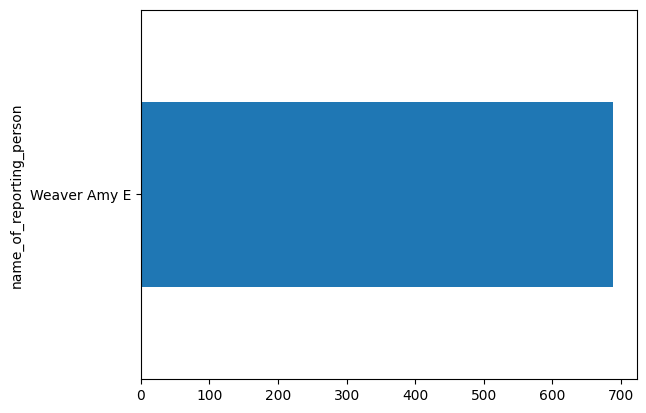

In [80]:
def show_acquired_disposed_common_stock_by_person_chart(form_4_dateframe):
    people = form_4_dataframe.groupby("name_of_reporting_person")['price'].sum()
    
    ax_codes = people.plot.barh()
    plt.show()
    

show_acquired_disposed_common_stock_by_person_chart(form_4_dataframe)
    

In [81]:
interested_company_form_4_index

,CIK,Company Name,Form Type,Date Filed,Filename
0,1108524,"SALESFORCE.COM, INC.",4,2022-01-05,https://www.sec.gov/Archives/edgar/data/110852...
1,1108524,"SALESFORCE.COM, INC.",4,2022-01-05,https://www.sec.gov/Archives/edgar/data/110852...
2,1108524,"SALESFORCE.COM, INC.",4,2022-01-06,https://www.sec.gov/Archives/edgar/data/110852...
3,1108524,"SALESFORCE.COM, INC.",4,2022-01-06,https://www.sec.gov/Archives/edgar/data/110852...
4,1108524,"SALESFORCE.COM, INC.",4,2022-01-10,https://www.sec.gov/Archives/edgar/data/110852...
...,...,...,...,...,...
416,1108524,"Salesforce, Inc.",4,2023-03-15,https://www.sec.gov/Archives/edgar/data/110852...
417,1108524,"Salesforce, Inc.",4,2023-03-15,https://www.sec.gov/Archives/edgar/data/110852...
418,1108524,"Salesforce, Inc.",4,2023-03-16,https://www.sec.gov/Archives/edgar/data/110852...
419,1108524,"Salesforce, Inc.",4,2023-03-17,https://www.sec.gov/Archives/edgar/data/110852...


In [82]:
def get_url_to_outstring(url, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print("Status Code:", response.status_code)
    SEC_API_sleep()
    return response.text

In [83]:
def get_XML_tree_from_form_string(form_string):
    form_lines = form_string.split('\n')
    XML_string = "".join(form_lines[form_lines.index('<XML>')+1:form_lines.index('</XML>')])
    return ET.fromstring(XML_string)

In [95]:
# get_forms_from_url_list ---> This function is too slow, consumes too much disk space
# TODO: Make this network efficient. Each file is approx 25KB for only 100 key bytes of info
# Way too much overhead.
# Grab a form, make it into a dataframe, add it up.
# Save quarterly dataframes as CSVs with ticker and quarter

def get_form_4_dataframe_from_index_dataframe(index_dataframe, run_once_override=run_once_override):
    if not run_once_override:
        return -1
    # set up form 4 return_dataframe
    return_dataframe = pd.DataFrame()
    # for form 4 URL
    for i, url in enumerate(index_dataframe["Filename"]):
        # get form 4 contents from URL
        file_contents = get_url_to_outstring(url, run_once_override)
        # parse XML_tree from form 4 contents
        XML_tree = get_XML_tree_from_form_string(file_contents)
        # construct form_4_dict from XML_tree
        form_4_dict = get_form_4_dict_from_XML_tree(XML_tree)
        # construct form_4_dataframe from form_4_dict
        form_4_dataframe = get_form_4_transaction_dataframe_from_form_4_dict(form_4_dict)
        # merge form_4_dataframe into return_dataframe
        return_dataframe = pd.concat([return_dataframe, form_4_dataframe])
        # print progress bar
        print_percent_complete(i, len(index_dataframe["Filename"]) - 1)
    print()
    return return_dataframe
            
            

In [96]:
get_form_4_dataframe_from_index_dataframe(interested_company_form_4_index, True)

AttributeError: 'NoneType' object has no attribute 'findall'